In [24]:
import numpy as np
import sys
sys.path.append('src/')
import MC_wrapper
import matplotlib.pyplot as plt

In [2]:
E1,E2 = 2.5,0.
Interactions = [[0.,0.,0.],[0.,E1,0.],[0.,0.,E2]]
Evalence=0

In [32]:
mc = MC_wrapper.MC(128,0,1,3,Interactions,Evalence,0.1)

polymer successfully generated
particles successfully added


In [46]:
steptot = 100
position = np.zeros((steptot+1),dtype=float)
position[0] = np.mean(MC_wrapper.to_xyz(mc.get_RNA_positions()[0],mc.size),axis=0)
for steps in range(steptot):
    mc.monte_carlo_steps(1)
    position[steps+1] = np.linalg.norm(np.mean(MC_wrapper.to_xyz(mc.get_RNA_positions()[0],mc.size),axis=0) - position[0])[0]**2


ValueError: setting an array element with a sequence.

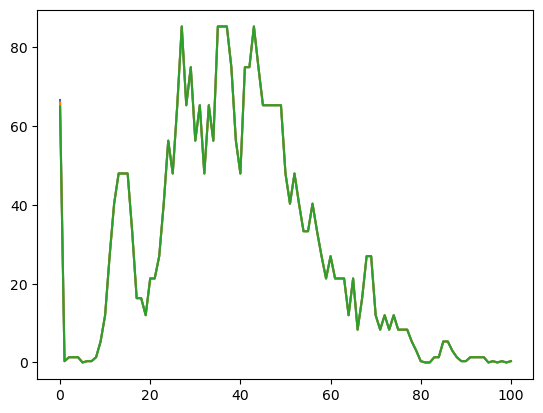

In [43]:
plt.plot(position)

2.3333333333333335

In [10]:
MC_wrapper.plot_simulation(mc)

In [5]:
mc.get_clusters()

(array([ 7025, 21109, 28615], dtype=int32), array([0, 1, 2], dtype=int32))

In [6]:
print(MC_wrapper.to_xyz(82,5))
print(MC_wrapper.to_xyz(108,5))

[3 1 2]
[4 1 3]


In [6]:
MC_wrapper.plot_simulation(mc)

/media/hcleroy/anaconda3/lib/python3.11/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


In [17]:
MC_wrapper.plot_simulation(mc,'simulation_2.html')

In [7]:
mc.monte_carlo_steps(100)

: 

In [5]:
print(mc.get_DHH1_positions())
print(mc.get_RNA_positions())
for dhh1 in mc.get_DHH1_positions():
    print(MC_wrapper.to_xyz(dhh1,mc.size))
for rna in mc.get_RNA_positions():
    coords = np.array([MC_wrapper.to_xyz(pos, mc.size) for pos in rna])
    print(coords)

[104  96 117]
[array([ 53,  77, 102,  81, 112,   8,  13,  44,  35,  19], dtype=int32)]
[4 0 4]
[3 4 1]
[4 3 2]
[[2 0 3]
 [3 0 2]
 [4 0 2]
 [3 1 1]
 [4 2 2]
 [0 1 3]
 [0 2 3]
 [1 3 4]
 [1 2 0]
 [0 3 4]]


In [51]:
def clip_segment_to_box(p1, p2, size):
    """Clip a line segment to the box boundaries."""
    min_bound = np.array([-0.5, -0.5, -0.5])
    max_bound = np.array([size - 1+0.5, size - 1+0.5, size - 1+0.5])

    direction = p2 - p1
    t_min = 0.0
    t_max = 1.0

    for i in range(3):
        if direction[i] == 0:
            if p1[i] < min_bound[i] or p1[i] > max_bound[i]:
                return None  # Segment is outside the box
        else:
            t1 = (min_bound[i] - p1[i]) / direction[i]
            t2 = (max_bound[i] - p2[i]) / direction[i]
            print(t1)
            print(t2)
            print()
            t_enter = min(t1, t2)
            t_exit = max(t1, t2)
            t_min = max(t_min, t_enter)
            t_max = min(t_max, t_exit)
            if t_min > t_max:
                return None  # No intersection, segment is outside the box

    if t_max < 0 or t_min > 1:
        return None  # Segment is outside the box
    print(t_min)
    print(t_max)
    # Compute the clipped segment
    clipped_p1 = p1 + t_min * direction
    clipped_p2 = p1 + t_max * direction
    return np.array([clipped_p1, clipped_p2])

def liang_barsky(p1,p2,size):
    # Unwrap positions to account for periodic boundary conditions
    delta = p2 - p1
    for dim in range(3):
        if delta[dim] > size / 2:
            delta[dim] -= size
        elif delta[dim] < -size / 2:
            delta[dim] += size
    p2 = p1 + delta
    x_min,y_min,z_min=-0.5,-0.5,-0.5
    x_max,y_max,z_max=size-0.5,size-0.5,size-0.5
    x1,y1,z1 = p1[0],p1[1],p1[2]
    x2,y2,z2 = p2[0],p2[1],p2[2]
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    p = [-dx, dx, -dy, dy, -dz, dz]
    q = [x1 - x_min, x_max - x1, y1 - y_min, y_max - y1, z1 - z_min, z_max - z1]
    t_enter = 0.0
    t_exit = 1.0

    for i in range(6):
        if p[i] == 0:  # Check if line is parallel to the clipping boundary
            if q[i] < 0:
                return None  # Line is outside and parallel, so completely discarded
        else:
            t = q[i] / p[i]
            if p[i] < 0:
                if t > t_enter:
                    t_enter = t
            else:
                if t < t_exit:
                    t_exit = t

    if t_enter > t_exit:
        return None  # Line is completely outside

    x1_clip = x1 + t_enter * dx
    y1_clip = y1 + t_enter * dy
    x2_clip = x1 + t_exit * dx
    y2_clip = y1 + t_exit * dy
    z1_clip = z1 + t_enter * dz
    z2_clip = z2 + t_exit * dz


    return np.array([[x1_clip, y1_clip, z1_clip],[x2_clip, y2_clip, z2_clip]])

In [52]:
liang_barsky(np.array([4.,2.,2.]),np.array([0.,1.,3.]),5)

array([[4. , 2. , 2. ],
       [4.5, 1.5, 3.5]])

In [15]:
mc.monte_carlo_step()

True

In [4]:
x1,y1,z1 = 0,1,0
x2,y2,z2 = 1,0,0
np.max(np.abs([x2-x1,y2-y1,z2-z1]))

1

In [29]:
box = B.BOX(5,3,0.,0.,[10.,0.],0.1)

In [31]:
box.get_neighbors(0,0,0).__len__()

26

In [27]:
box.total_energy()

-20.0

In [26]:
box.build_clusters()

(array([52, 71, 90], dtype=int32), array([0], dtype=int32))

In [25]:
box.monte_carlo_step()

True

In [5]:
moves= np.array(mc.monte_carlo_steps(step_tot))

print(np.where(moves==True)[0].shape)

(206676,)


In [6]:
print(np.where(moves==True)[0].shape[0]/step_tot)

0.206676


In [7]:
indices,starts = mc.get_clusters()

In [8]:
print(starts)
print(np.sum(np.diff(starts))/starts.shape[0])

[ 0  1  4  5  7  8 13 15 18 19 20 21 23 26 27 29 31 32 34 35 36 37 39 40
 41 44 45 48 51 56 57 59 60 61 62 67 68 70 76 82 83 84 86 94 99]
2.2


In [9]:
print(mc.average_cluster_size())

2.2222222222222223


In [4]:
mc = MC.MC(100,100,0,0,interactions=Interactions,temperature=1.)
av_c_size = np.zeros(check_step,dtype=float)
for n_steps in range(check_step):
    mc.monte_carlo_steps(step_tot//check_step)
    av_c_size[n_steps] = np.mean(mc.box.cluster_size())

In [26]:
x = np.random.randint(1,4)
y = np.random.randint(1,4)
z = np.random.randint(1,4)
print((x,y,z))
if (x,y,z) != (1,2,3):
    print('ok')

(1, 2, 3)


In [3]:
box.cluster_size()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
box.monte_carlo_steps(10**6)

In [10]:
c_size = box.cluster_size()
np.mean(c_size)

33.333333333333336

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([15., 18., 21., 24., 27., 30., 33., 36., 39., 42., 45.]),
 <BarContainer object of 10 artists>)

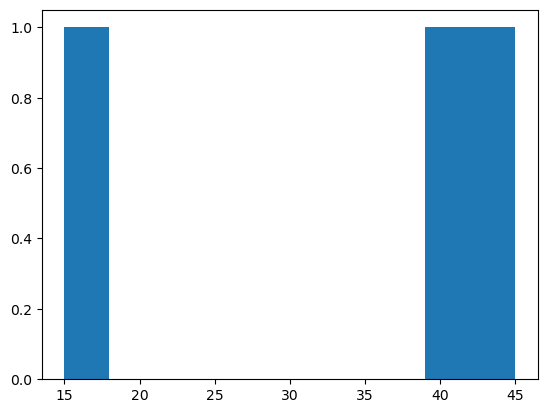

In [11]:
plt.hist(box.cluster_size())

In [9]:
np.where(box.lattice==1)[0].shape

(100,)

In [18]:
A

[[1, 2, 3]]

In [17]:
A.append([1,2,3])